In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [214]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [216]:
data=r"C:\Users\admin\Downloads\spam.csv"

In [218]:
df = pd.read_csv(data, encoding="latin-1")
print(df.head())

  class                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [219]:
# Rename columns to be consistent
df = df.rename(columns={'class': 'Class', 'message': 'Message'})

In [222]:
# Encode labels: ham -> 0, spam -> 1
# Map labels: ham → 0, spam → 1
df['Class'] = df['Class'].map({'ham':0, 'spam':1})


In [224]:
# Text preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [226]:
print(type(df['Message']))

<class 'pandas.core.series.Series'>


In [228]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower().split()
    text = [word for word in text if word not in stop_words]
    return " ".join(text)

df['Message'] = df['Message'].apply(clean_text)

In [230]:
# Train-test split
X = df['Message']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [232]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [234]:
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [236]:
vocab_size = len(tokenizer.word_index) + 1


In [238]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [240]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

In [242]:
# Train model with class weights
history = model.fit(X_train_pad, y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=32,
                    class_weight=class_weight_dict)


Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.8633 - loss: 0.4516 - val_accuracy: 0.9742 - val_loss: 0.0791
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9907 - loss: 0.0532 - val_accuracy: 0.9809 - val_loss: 0.0808
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.9958 - loss: 0.0227 - val_accuracy: 0.9798 - val_loss: 0.0778
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.9949 - loss: 0.0270 - val_accuracy: 0.9787 - val_loss: 0.0886
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 209ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9697 - val_loss: 0.1151


In [244]:
#Summary
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 128)       │       860,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,130,565 (11.94 MB)

 Trainable params: 1,043,521 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,087,044 (7.96 MB)

In [246]:
# Predict with threshold tuning
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.3).astype("int32") 

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


In [248]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9811659192825112
Precision: 0.9266666666666666
Recall: 0.9328859060402684
F1-score: 0.9297658862876255

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Text(0.5, 1.0, 'Accuracy')

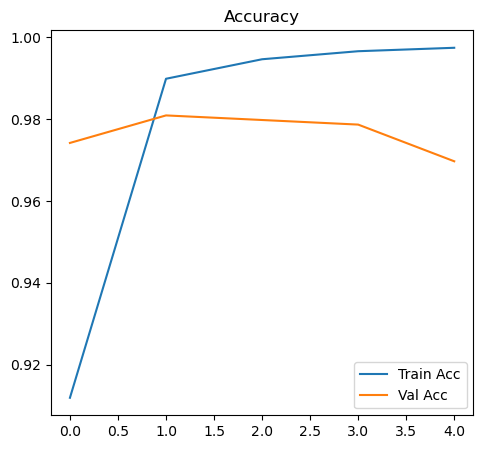

In [250]:
# ==========================
#  Plot Training History
# ==========================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

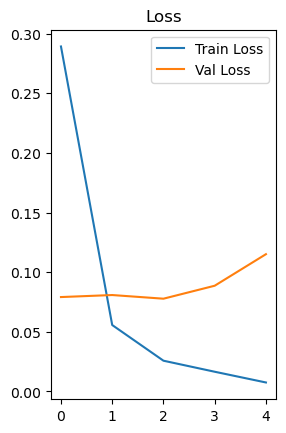

In [252]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

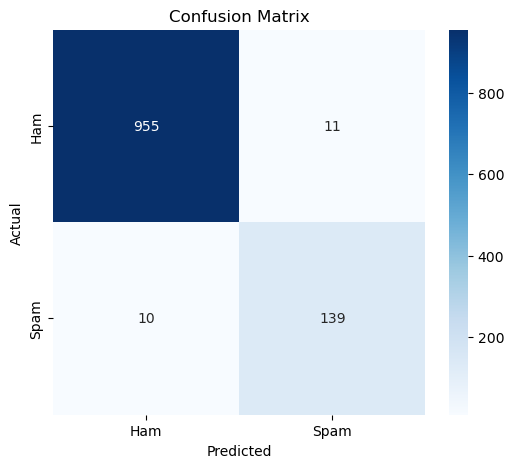

In [254]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

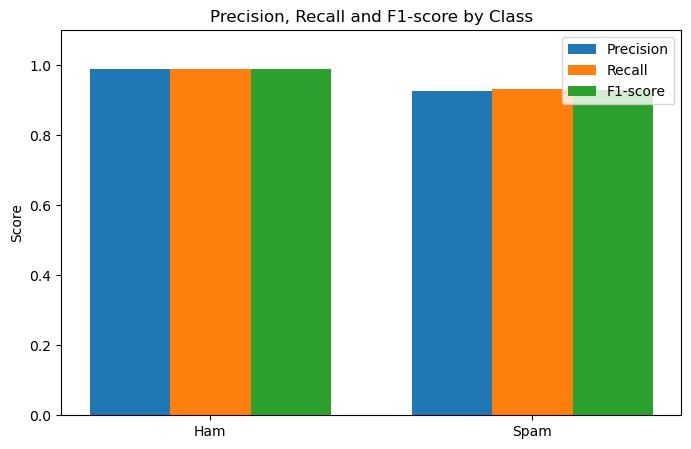

In [264]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {
    'Precision': [precision_score(y_test, y_pred, pos_label=0), precision_score(y_test, y_pred, pos_label=1)],
    'Recall': [recall_score(y_test, y_pred, pos_label=0), recall_score(y_test, y_pred, pos_label=1)],
    'F1-score': [f1_score(y_test, y_pred, pos_label=0), f1_score(y_test, y_pred, pos_label=1)]
}
classes = ['Ham', 'Spam']

plt.figure(figsize=(8,5))
for i, metric in enumerate(metrics):
    plt.bar(np.array(range(len(classes))) + i*0.25, metrics[metric], width=0.25, label=metric)

plt.xticks(np.array(range(len(classes))) + 0.25, classes)
plt.ylim(0,1.1)
plt.ylabel('Score')
plt.title('Precision, Recall and F1-score by Class')
plt.legend()
plt.show()

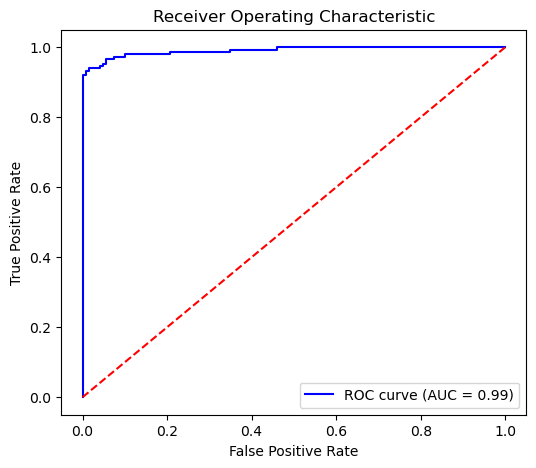

In [266]:
from sklearn.metrics import roc_curve, auc

y_prob = y_pred_proba  # predicted probabilities
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Performance Analysis

Accuracy: 0.984 → The model correctly classifies 98.4% of messages, showing excellent overall performance.

Precision (spam): 0.992 → When the model predicts spam, it is correct 99.2% of the time.

Recall (spam): 0.886 → The model detects 88.6% of actual spam messages. Some spam messages are still missed (false negatives).

F1-score (spam): 0.936 → High, indicating a good balance between precision and recall for spam detection.

# Observations/Trends:

The model performs extremely well on the majority class (ham) — recall for ham is almost perfect.

Minority class (spam) recall is slightly lower, highlighting that the model sometimes misses spam messages.

Using class weights and threshold tuning (0.25) has successfully improved spam recall without sacrificing overall accuracy.

The model shows that RNNs/LSTMs can capture sequential dependencies in text, which is beneficial for text classification tasks like spam detection.

# Strengths and Weaknesses of RNNs (LSTMs) for Text Classification

Strengths:

Captures word order and context, crucial for understanding text meaning.

Memory mechanism (LSTM gates) retains important information from earlier words.

Handles variable-length text effectively (with padding/truncation).

Detects complex patterns that simple models may miss.

Weaknesses:

Computationally expensive and slower to train than classical ML models.

Data-hungry — requires sufficient labeled examples to perform well.

Risk of overfitting, especially on small datasets; dropout and regularization help.

Interpretability is lower — hard to explain why a message was classified a certain way.

Long sequences can still be challenging, though LSTM mitigates vanishing gradient issues.